<a href="https://colab.research.google.com/github/ajit2704/Practical-Reinforcement-Learning-With-Colab/blob/master/CEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
python-dev is already the newest version (2.7.14-2ubuntu1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
The following additional packages will be installed:
  autotools-dev cmake-data dbus ffmpeg file freeglut3 gir1.2-glib-2.0
  gir1.2-ibus-1.0 i965-va-driver libaacs0 libapparmor1 libarchive13 libasound2
  libasound2-data libasound2-dev libass9 libasyncns0 libavc1394-0 libavcodec57
  libavdevice57 libavfilter6 libavformat57 libavresample3 libavutil55
  libbdplus0 libbluray2 libboost-atomic-dev libboost-atomic1.62-dev
  libboost-atomic1.62.0 libboost-chrono-dev libboost-chrono1.62-dev
  libboost-chrono1.62.0 libboost-context-dev libboost-context1.62-dev
  libboost-context1.62.0 libboost-coroutine-dev libboost-coroutine1.62-dev
  libboost-

Get:17 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libapparmor1 amd64 2.11.0-2ubuntu17.1 [28.9 kB]
Get:18 http://archive.ubuntu.com/ubuntu artful/main amd64 libdbus-1-3 amd64 1.10.22-1ubuntu1 [165 kB]
Get:19 http://archive.ubuntu.com/ubuntu artful/main amd64 dbus amd64 1.10.22-1ubuntu1 [144 kB]
Get:20 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libmagic-mgc amd64 1:5.32-1ubuntu0.1 [184 kB]
Get:21 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libmagic1 amd64 1:5.32-1ubuntu0.1 [68.4 kB]
Get:22 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 file amd64 1:5.32-1ubuntu0.1 [22.0 kB]
Get:23 http://archive.ubuntu.com/ubuntu artful/main amd64 libelf1 amd64 0.170-0.1 [44.3 kB]
Get:24 http://archive.ubuntu.com/ubuntu artful/main amd64 libfribidi0 amd64 0.19.7-1 [25.1 kB]
Get:25 http://archive.ubuntu.com/ubuntu artful/main amd64 libglib2.0-data all 2.54.1-1ubuntu1 [4,250 B]
Get:26 http://archive.ubuntu.com/ubuntu artful/main amd64 libslang2 amd

Get:90 http://archive.ubuntu.com/ubuntu artful/universe amd64 libopencv-imgproc3.1 amd64 3.1.0+dfsg1-1~exp1ubuntu3 [778 kB]
Get:91 http://archive.ubuntu.com/ubuntu artful/universe amd64 libpostproc54 amd64 7:3.3.4-2 [50.5 kB]
Get:92 http://archive.ubuntu.com/ubuntu artful/main amd64 libfftw3-double3 amd64 3.3.6p2-1 [727 kB]
Get:93 http://archive.ubuntu.com/ubuntu artful/main amd64 libsamplerate0 amd64 0.1.9-1 [938 kB]
Get:94 http://archive.ubuntu.com/ubuntu artful/universe amd64 librubberband2v5 amd64 1.8.1-6ubuntu2 [85.3 kB]
Get:95 http://archive.ubuntu.com/ubuntu artful/universe amd64 libswscale4 amd64 7:3.3.4-2 [150 kB]
Get:96 http://archive.ubuntu.com/ubuntu artful/universe amd64 libavfilter6 amd64 7:3.3.4-2 [812 kB]
Get:97 http://archive.ubuntu.com/ubuntu artful/main amd64 libcaca0 amd64 0.99.beta19-2build2~gcc5.2 [202 kB]
Get:98 http://archive.ubuntu.com/ubuntu artful/main amd64 libcdio13 amd64 0.83-4.2ubuntu1 [53.0 kB]
Get:99 http://archive.ubuntu.com/ubuntu artful/main amd64 li

Get:130 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-cursor0 amd64 1.14.0-1ubuntu0.1 [9,890 B]
Get:131 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-server0 amd64 1.14.0-1ubuntu0.1 [28.5 kB]
Get:132 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libgbm1 amd64 17.2.8-0ubuntu0~17.10.1 [24.4 kB]
Get:133 http://archive.ubuntu.com/ubuntu artful/main amd64 libboost-system1.62.0 amd64 1.62.0+dfsg-4build3 [9,212 B]
Get:134 http://archive.ubuntu.com/ubuntu artful/main amd64 libcapnp-0.5.3 amd64 0.5.3-2ubuntu2 [569 kB]
Get:135 http://archive.ubuntu.com/ubuntu artful/main amd64 libboost-filesystem1.62.0 amd64 1.62.0+dfsg-4build3 [38.6 kB]
Get:136 http://archive.ubuntu.com/ubuntu artful/main amd64 libmircore1 amd64 0.28.0+17.10.20171011.1-0ubuntu1 [31.5 kB]
Get:137 http://archive.ubuntu.com/ubuntu artful/main amd64 libmircommon7 amd64 0.28.0+17.10.20171011.1-0ubuntu1 [73.2 kB]
Get:138 http://archive.ubuntu.com/ubuntu artful/main amd64 li

Get:169 http://archive.ubuntu.com/ubuntu artful/main amd64 libboost-context1.62.0 amd64 1.62.0+dfsg-4build3 [8,220 B]
Get:170 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-context1.62-dev amd64 1.62.0+dfsg-4build3 [6,488 B]
Get:171 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-context-dev amd64 1.62.0.1 [3,062 B]
Get:172 http://archive.ubuntu.com/ubuntu artful/main amd64 libboost-thread1.62.0 amd64 1.62.0+dfsg-4build3 [47.3 kB]
Get:173 http://archive.ubuntu.com/ubuntu artful/main amd64 libboost-coroutine1.62.0 amd64 1.62.0+dfsg-4build3 [19.7 kB]
Get:174 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-coroutine1.62-dev amd64 1.62.0+dfsg-4build3 [20.2 kB]
Get:175 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-coroutine-dev amd64 1.62.0.1 [3,126 B]
Get:176 http://archive.ubuntu.com/ubuntu artful/main amd64 libboost-date-time1.62.0 amd64 1.62.0+dfsg-4build3 [19.8 kB]
Get:177 http://archive.ubuntu.com/ubuntu artful/main am

Get:206 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-mpi1.62.0 amd64 1.62.0+dfsg-4build3 [46.4 kB]
Get:207 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-graph-parallel1.62.0 amd64 1.62.0+dfsg-4build3 [62.0 kB]
Get:208 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-graph-parallel1.62-dev amd64 1.62.0+dfsg-4build3 [64.0 kB]
Get:209 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-graph-parallel-dev amd64 1.62.0.1 [2,998 B]
Get:210 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-regex1.62-dev amd64 1.62.0+dfsg-4build3 [310 kB]
Get:211 http://archive.ubuntu.com/ubuntu artful/main amd64 libboost-iostreams1.62.0 amd64 1.62.0+dfsg-4build3 [27.4 kB]
Get:212 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-iostreams1.62-dev amd64 1.62.0+dfsg-4build3 [32.8 kB]
Get:213 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-iostreams-dev amd64 1.62.0.1 [2,860 B]
Get:214 http://archive.ubunt

Get:245 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-random1.62-dev amd64 1.62.0+dfsg-4build3 [10.5 kB]
Get:246 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-random-dev amd64 1.62.0.1 [2,866 B]
Get:247 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-regex-dev amd64 1.62.0.1 [3,120 B]
Get:248 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-serialization-dev amd64 1.62.0.1 [3,094 B]
Get:249 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-signals1.62.0 amd64 1.62.0+dfsg-4build3 [30.6 kB]
Get:250 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-signals1.62-dev amd64 1.62.0+dfsg-4build3 [33.4 kB]
Get:251 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-signals-dev amd64 1.62.0.1 [2,928 B]
Get:252 http://archive.ubuntu.com/ubuntu artful/main amd64 libboost-system-dev amd64 1.62.0.1 [3,006 B]
Get:253 http://archive.ubuntu.com/ubuntu artful/universe amd64 libboost-test-dev amd64 1

Get:285 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-shape0-dev amd64 1.12-1ubuntu1 [7,056 B]
Get:286 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-xfixes0-dev amd64 1.12-1ubuntu1 [11.6 kB]
Get:287 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-sync-dev amd64 1.12-1ubuntu1 [10.5 kB]
Get:288 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-present-dev amd64 1.12-1ubuntu1 [6,868 B]
Get:289 http://archive.ubuntu.com/ubuntu artful/main amd64 libxshmfence-dev amd64 1.2-1 [3,676 B]
Get:290 http://archive.ubuntu.com/ubuntu artful/main amd64 libx11-xcb-dev amd64 2:1.6.4-3 [9,660 B]
Get:291 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-bin amd64 1.14.0-1ubuntu0.1 [18.8 kB]
Get:292 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-dev amd64 1.14.0-1ubuntu0.1 [98.1 kB]
Get:293 http://archive.ubuntu.com/ubuntu artful/main amd64 libmircore-dev amd64 0.28.0+17.10.20171011.1-0ubuntu1 [26.7 kB]
Get:294 http://arch

Get:318 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libgl1-mesa-dev amd64 17.2.8-0ubuntu0~17.10.1 [4,436 B]
Get:319 http://archive.ubuntu.com/ubuntu artful/main amd64 libglu1-mesa-dev amd64 9.0.0-2.1build1 [206 kB]
Get:320 http://archive.ubuntu.com/ubuntu artful/main amd64 libibus-1.0-dev amd64 1.5.14-2ubuntu1 [143 kB]
Get:321 http://archive.ubuntu.com/ubuntu artful/main amd64 libice-dev amd64 2:1.0.9-2 [46.8 kB]
Get:322 http://archive.ubuntu.com/ubuntu artful/main amd64 libpixman-1-dev amd64 0.34.0-1 [245 kB]
Get:323 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libpulse-mainloop-glib0 amd64 1:10.0-2ubuntu3.1 [22.0 kB]
Get:324 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libpulse-dev amd64 1:10.0-2ubuntu3.1 [81.5 kB]
Get:325 http://archive.ubuntu.com/ubuntu artful/universe amd64 libsndio-dev amd64 1.1.0-3 [13.3 kB]
Get:326 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libxcursor-dev amd64 1:1.1.14-3ubuntu0.1 [26.5 kB]
Get:327 http

Get:359 http://archive.ubuntu.com/ubuntu artful/main amd64 libxres-dev amd64 2:1.0.7-3 [6,530 B]
Get:360 http://archive.ubuntu.com/ubuntu artful/main amd64 libxtst6 amd64 2:1.2.3-1 [12.8 kB]
Get:361 http://archive.ubuntu.com/ubuntu artful/main amd64 x11proto-record-dev all 1.14.2-1 [33.6 kB]
Get:362 http://archive.ubuntu.com/ubuntu artful/main amd64 libxtst-dev amd64 2:1.2.3-1 [15.2 kB]
Get:363 http://archive.ubuntu.com/ubuntu artful/main amd64 libxvmc1 amd64 2:1.0.10-1 [13.7 kB]
Get:364 http://archive.ubuntu.com/ubuntu artful/main amd64 libxvmc-dev amd64 2:1.0.10-1 [21.3 kB]
Get:365 http://archive.ubuntu.com/ubuntu artful/main amd64 x11proto-xf86dga-dev all 2.1-3 [7,288 B]
Get:366 http://archive.ubuntu.com/ubuntu artful/main amd64 libxxf86dga-dev amd64 2:1.1.4-1 [17.6 kB]
Get:367 http://archive.ubuntu.com/ubuntu artful-updates/universe amd64 mesa-va-drivers amd64 17.2.8-0ubuntu0~17.10.1 [1,532 kB]
Get:368 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 mesa-vdpau-drivers am

Extracting templates from packages: 100%
Selecting previously unselected package cmake-data.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-cmake-data_3.9.1-1_all.deb ...
Unpacking cmake-data (3.9.1-1) ...
Selecting previously unselected package liblzo2-2:amd64.
Preparing to unpack .../01-liblzo2-2_2.08-1.2_amd64.deb ...
Unpacking liblzo2-2:amd64 (2.08-1.2) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../02-libarchive13_3.2.2-3.1_amd64.deb ...
Unpacking libarchive13:amd64 (3.2.2-3.1) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../03-libjsoncpp1_1.7.4-3_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3) ...
Selecting previously unselected package librhash0.
Preparing to unpack .../04-librhash0_1.3.4-3_amd64.deb ...
Unpacking librhash0 (1.3.4-3) ...
Selecting previously unselected package libuv1:amd64.
Preparing to unpack .../05-libuv1_1.9.1-3_amd64.deb ...

Selecting previously unselected package xkb-data.
Preparing to unpack .../015-xkb-data_2.19-1.1ubuntu1_all.deb ...
Unpacking xkb-data (2.19-1.1ubuntu1) ...
Selecting previously unselected package libgirepository-1.0-1:amd64.
Preparing to unpack .../016-libgirepository-1.0-1_1.54.1-1_amd64.deb ...
Unpacking libgirepository-1.0-1:amd64 (1.54.1-1) ...
Selecting previously unselected package gir1.2-glib-2.0:amd64.
Preparing to unpack .../017-gir1.2-glib-2.0_1.54.1-1_amd64.deb ...
Unpacking gir1.2-glib-2.0:amd64 (1.54.1-1) ...
Selecting previously unselected package libdrm-common.
Preparing to unpack .../018-libdrm-common_2.4.83-1_all.deb ...
Unpacking libdrm-common (2.4.83-1) ...
Selecting previously unselected package libdrm2:amd64.
Preparing to unpack .../019-libdrm2_2.4.83-1_amd64.deb ...
Unpacking libdrm2:amd64 (2.4.83-1) ...
Selecting previously unselected package libnuma1:amd64.
Preparing to unpack .../020-libnuma1_2.0.11-2.1_amd64.deb ...
Unpacking libnuma1:amd64 (2.0.11-2.1) ...
Se

Selecting previously unselected package libcairo2:amd64.
Preparing to unpack .../043-libcairo2_1.14.10-1ubuntu1_amd64.deb ...
Unpacking libcairo2:amd64 (1.14.10-1ubuntu1) ...
Selecting previously unselected package libtheora0:amd64.
Preparing to unpack .../044-libtheora0_1.1.1+dfsg.1-14_amd64.deb ...
Unpacking libtheora0:amd64 (1.1.1+dfsg.1-14) ...
Selecting previously unselected package libtwolame0:amd64.
Preparing to unpack .../045-libtwolame0_0.3.13-2_amd64.deb ...
Unpacking libtwolame0:amd64 (0.3.13-2) ...
Selecting previously unselected package libvorbis0a:amd64.
Preparing to unpack .../046-libvorbis0a_1.3.5-4ubuntu0.2_amd64.deb ...
Unpacking libvorbis0a:amd64 (1.3.5-4ubuntu0.2) ...
Selecting previously unselected package libvorbisenc2:amd64.
Preparing to unpack .../047-libvorbisenc2_1.3.5-4ubuntu0.2_amd64.deb ...
Unpacking libvorbisenc2:amd64 (1.3.5-4ubuntu0.2) ...
Selecting previously unselected package libvpx4:amd64.
Preparing to unpack .../048-libvpx4_1.6.1-3_amd64.deb ...
Unp

Selecting previously unselected package libavformat57:amd64.
Preparing to unpack .../072-libavformat57_7%3a3.3.4-2_amd64.deb ...
Unpacking libavformat57:amd64 (7:3.3.4-2) ...
Selecting previously unselected package libavresample3:amd64.
Preparing to unpack .../073-libavresample3_7%3a3.3.4-2_amd64.deb ...
Unpacking libavresample3:amd64 (7:3.3.4-2) ...
Selecting previously unselected package libbs2b0:amd64.
Preparing to unpack .../074-libbs2b0_3.1.0+dfsg-2.2_amd64.deb ...
Unpacking libbs2b0:amd64 (3.1.0+dfsg-2.2) ...
Selecting previously unselected package libflite1:amd64.
Preparing to unpack .../075-libflite1_2.0.0-release-4_amd64.deb ...
Unpacking libflite1:amd64 (2.0.0-release-4) ...
Selecting previously unselected package libtbb2:amd64.
Preparing to unpack .../076-libtbb2_2017~U7-6_amd64.deb ...
Unpacking libtbb2:amd64 (2017~U7-6) ...
Selecting previously unselected package libopencv-core3.1:amd64.
Preparing to unpack .../077-libopencv-core3.1_3.1.0+dfsg1-1~exp1ubuntu3_amd64.deb ...


Selecting previously unselected package libpciaccess0:amd64.
Preparing to unpack .../099-libpciaccess0_0.13.4-1ubuntu1_amd64.deb ...
Unpacking libpciaccess0:amd64 (0.13.4-1ubuntu1) ...
Selecting previously unselected package libdrm-intel1:amd64.
Preparing to unpack .../100-libdrm-intel1_2.4.83-1_amd64.deb ...
Unpacking libdrm-intel1:amd64 (2.4.83-1) ...
Selecting previously unselected package libdrm-nouveau2:amd64.
Preparing to unpack .../101-libdrm-nouveau2_2.4.83-1_amd64.deb ...
Unpacking libdrm-nouveau2:amd64 (2.4.83-1) ...
Selecting previously unselected package libdrm-radeon1:amd64.
Preparing to unpack .../102-libdrm-radeon1_2.4.83-1_amd64.deb ...
Unpacking libdrm-radeon1:amd64 (2.4.83-1) ...
Selecting previously unselected package libllvm5.0:amd64.
Preparing to unpack .../103-libllvm5.0_1%3a5.0-3_amd64.deb ...
Unpacking libllvm5.0:amd64 (1:5.0-3) ...
Selecting previously unselected package libsensors4:amd64.
Preparing to unpack .../104-libsensors4_1%3a3.4.0-4_amd64.deb ...
Unpack

Unpacking libprotobuf-lite10:amd64 (3.0.0-9ubuntu5) ...
Selecting previously unselected package libmirprotobuf3:amd64.
Preparing to unpack .../127-libmirprotobuf3_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmirprotobuf3:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libxkbcommon0:amd64.
Preparing to unpack .../128-libxkbcommon0_0.7.1-2_amd64.deb ...
Unpacking libxkbcommon0:amd64 (0.7.1-2) ...
Selecting previously unselected package libmirclient9:amd64.
Preparing to unpack .../129-libmirclient9_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmirclient9:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libxcb-xfixes0:amd64.
Preparing to unpack .../130-libxcb-xfixes0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-xfixes0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libegl1-mesa:amd64.
Preparing to unpack .../131-libegl1-mesa_17.2.8-0ubuntu0~17.10.1_amd64.deb ...
Unpackin

Selecting previously unselected package libboost-chrono1.62.0:amd64.
Preparing to unpack .../154-libboost-chrono1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-chrono1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-chrono1.62-dev:amd64.
Preparing to unpack .../155-libboost-chrono1.62-dev_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-chrono1.62-dev:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-chrono-dev:amd64.
Preparing to unpack .../156-libboost-chrono-dev_1.62.0.1_amd64.deb ...
Unpacking libboost-chrono-dev:amd64 (1.62.0.1) ...
Selecting previously unselected package libboost-context1.62.0:amd64.
Preparing to unpack .../157-libboost-context1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-context1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-context1.62-dev:amd64.
Preparing to unpack .../158-libboost-context1.62-dev_1.62.0+dfsg-4build3_amd64.

Selecting previously unselected package libboost-graph1.62.0:amd64.
Preparing to unpack .../178-libboost-graph1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-graph1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-test1.62.0:amd64.
Preparing to unpack .../179-libboost-test1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-test1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-test1.62-dev:amd64.
Preparing to unpack .../180-libboost-test1.62-dev_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-test1.62-dev:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-graph1.62-dev:amd64.
Preparing to unpack .../181-libboost-graph1.62-dev_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-graph1.62-dev:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-graph-dev:amd64.
Preparing to unpack .../182-libboost-graph-dev_1.62.0.1_amd64.deb ...
Un

Unpacking libboost-locale1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-locale1.62-dev:amd64.
Preparing to unpack .../203-libboost-locale1.62-dev_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-locale1.62-dev:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-locale-dev:amd64.
Preparing to unpack .../204-libboost-locale-dev_1.62.0.1_amd64.deb ...
Unpacking libboost-locale-dev:amd64 (1.62.0.1) ...
Selecting previously unselected package libboost-log1.62.0.
Preparing to unpack .../205-libboost-log1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-log1.62.0 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-thread1.62-dev:amd64.
Preparing to unpack .../206-libboost-thread1.62-dev_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-thread1.62-dev:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-log1.62-dev.
Preparing to unpack .../207-libboost-log1.6

Selecting previously unselected package libboost-program-options-dev:amd64.
Preparing to unpack .../229-libboost-program-options-dev_1.62.0.1_amd64.deb ...
Unpacking libboost-program-options-dev:amd64 (1.62.0.1) ...
Selecting previously unselected package libboost-python1.62-dev.
Preparing to unpack .../230-libboost-python1.62-dev_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-python1.62-dev (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-python-dev.
Preparing to unpack .../231-libboost-python-dev_1.62.0.1_amd64.deb ...
Unpacking libboost-python-dev (1.62.0.1) ...
Selecting previously unselected package libboost-random1.62.0:amd64.
Preparing to unpack .../232-libboost-random1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-random1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libboost-random1.62-dev:amd64.
Preparing to unpack .../233-libboost-random1.62-dev_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-ran

Selecting previously unselected package x11proto-dmx-dev.
Preparing to unpack .../254-x11proto-dmx-dev_1%3a2.3.1-2_all.deb ...
Unpacking x11proto-dmx-dev (1:2.3.1-2) ...
Selecting previously unselected package libdmx-dev:amd64.
Preparing to unpack .../255-libdmx-dev_1%3a1.1.3-1_amd64.deb ...
Unpacking libdmx-dev:amd64 (1:1.1.3-1) ...
Selecting previously unselected package libdrm-dev:amd64.
Preparing to unpack .../256-libdrm-dev_2.4.83-1_amd64.deb ...
Unpacking libdrm-dev:amd64 (2.4.83-1) ...
Selecting previously unselected package x11proto-dri2-dev.
Preparing to unpack .../257-x11proto-dri2-dev_2.8-2_all.deb ...
Unpacking x11proto-dri2-dev (2.8-2) ...
Selecting previously unselected package x11proto-gl-dev.
Preparing to unpack .../258-x11proto-gl-dev_1.4.17-1_all.deb ...
Unpacking x11proto-gl-dev (1.4.17-1) ...
Selecting previously unselected package x11proto-xext-dev.
Preparing to unpack .../259-x11proto-xext-dev_7.3.0-1_all.deb ...
Unpacking x11proto-xext-dev (7.3.0-1) ...
Selecting

Selecting previously unselected package libmircore-dev:amd64.
Preparing to unpack .../281-libmircore-dev_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmircore-dev:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libprotobuf10:amd64.
Preparing to unpack .../282-libprotobuf10_3.0.0-9ubuntu5_amd64.deb ...
Unpacking libprotobuf10:amd64 (3.0.0-9ubuntu5) ...
Selecting previously unselected package libprotobuf-dev:amd64.
Preparing to unpack .../283-libprotobuf-dev_3.0.0-9ubuntu5_amd64.deb ...
Unpacking libprotobuf-dev:amd64 (3.0.0-9ubuntu5) ...
Selecting previously unselected package libxkbcommon-dev.
Preparing to unpack .../284-libxkbcommon-dev_0.7.1-2_amd64.deb ...
Unpacking libxkbcommon-dev (0.7.1-2) ...
Selecting previously unselected package libmircommon-dev:amd64.
Preparing to unpack .../285-libmircommon-dev_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmircommon-dev:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting pr

Preparing to unpack .../305-mesa-common-dev_17.2.8-0ubuntu0~17.10.1_amd64.deb ...
Unpacking mesa-common-dev:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Selecting previously unselected package libgl1-mesa-dev:amd64.
Preparing to unpack .../306-libgl1-mesa-dev_17.2.8-0ubuntu0~17.10.1_amd64.deb ...
Unpacking libgl1-mesa-dev:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Selecting previously unselected package libglu1-mesa-dev:amd64.
Preparing to unpack .../307-libglu1-mesa-dev_9.0.0-2.1build1_amd64.deb ...
Unpacking libglu1-mesa-dev:amd64 (9.0.0-2.1build1) ...
Selecting previously unselected package libibus-1.0-dev:amd64.
Preparing to unpack .../308-libibus-1.0-dev_1.5.14-2ubuntu1_amd64.deb ...
Unpacking libibus-1.0-dev:amd64 (1.5.14-2ubuntu1) ...
Selecting previously unselected package libice-dev:amd64.
Preparing to unpack .../309-libice-dev_2%3a1.0.9-2_amd64.deb ...
Unpacking libice-dev:amd64 (2:1.0.9-2) ...
Selecting previously unselected package libpixman-1-dev.
Preparing to unpack .../310-libpixman-1-d

Preparing to unpack .../332-libxmu-headers_2%3a1.1.2-2_all.deb ...
Unpacking libxmu-headers (2:1.1.2-2) ...
Selecting previously unselected package libxmu-dev:amd64.
Preparing to unpack .../333-libxmu-dev_2%3a1.1.2-2_amd64.deb ...
Unpacking libxmu-dev:amd64 (2:1.1.2-2) ...
Selecting previously unselected package libxpm-dev:amd64.
Preparing to unpack .../334-libxpm-dev_1%3a3.5.12-1_amd64.deb ...
Unpacking libxpm-dev:amd64 (1:3.5.12-1) ...
Selecting previously unselected package libxaw7-dev:amd64.
Preparing to unpack .../335-libxaw7-dev_2%3a1.0.13-1_amd64.deb ...
Unpacking libxaw7-dev:amd64 (2:1.0.13-1) ...
Selecting previously unselected package libxcomposite1:amd64.
Preparing to unpack .../336-libxcomposite1_1%3a0.4.4-2_amd64.deb ...
Unpacking libxcomposite1:amd64 (1:0.4.4-2) ...
Selecting previously unselected package x11proto-composite-dev.
Preparing to unpack .../337-x11proto-composite-dev_1%3a0.4.2-2_all.deb ...
Unpacking x11proto-composite-dev (1:0.4.2-2) ...
Selecting previously 

Selecting previously unselected package python-opengl.
Preparing to unpack .../359-python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package swig3.0.
Preparing to unpack .../360-swig3.0_3.0.10-1.2_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.2) ...
Selecting previously unselected package swig.
Preparing to unpack .../361-swig_3.0.10-1.2_amd64.deb ...
Unpacking swig (3.0.10-1.2) ...
Selecting previously unselected package tcpd.
Preparing to unpack .../362-tcpd_7.6.q-26_amd64.deb ...
Unpacking tcpd (7.6.q-26) ...
Selecting previously unselected package i965-va-driver:amd64.
Preparing to unpack .../363-i965-va-driver_1.8.3-1ubuntu1_amd64.deb ...
Unpacking i965-va-driver:amd64 (1.8.3-1ubuntu1) ...
Selecting previously unselected package va-driver-all:amd64.
Preparing to unpack .../364-va-driver-all_1.8.3-2_amd64.deb ...
Unpacking va-driver-all:amd64 (1.8.3-2) ...
Selecting previously unselected package vdpau-driver-all:amd64.
Pre

Setting up libxinerama1:amd64 (2:1.1.3-1) ...
Setting up libxcb-dri2-0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-dri3-0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-glx0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-randr0:amd64 (1.12-1ubuntu1) ...
Setting up libtwolame0:amd64 (0.3.13-2) ...
Setting up libraw1394-11:amd64 (2.1.2-1) ...
Setting up libxcb-xfixes0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-render0:amd64 (1.12-1ubuntu1) ...
Setting up libopenjp2-7:amd64 (2.2.0-1) ...
Setting up libasyncns0:amd64 (0.8-6) ...
Setting up libboost-date-time1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libcdio13:amd64 (0.83-4.2ubuntu1) ...
Setting up libx264-148:amd64 (2:0.148.2795+gitaaa9aa8-1) ...
Setting up x11proto-dmx-dev (1:2.3.1-2) ...
Setting up libxdamage1:amd64 (1:1.1.4-3) ...
Setting up libboost1.62-tools-dev (1.62.0+dfsg-4build3) ...
Setting up swig3.0 (3.0.10-1.2) ...
Setting up libxfixes3:amd64 (1:5.0.3-1) ...
Setting up libmircore-dev:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) 

Setting up libxtst6:amd64 (2:1.2.3-1) ...
Setting up libmagic-mgc (1:5.32-1ubuntu0.1) ...
Setting up libva1:amd64 (1.8.3-2) ...
Setting up libasound2:amd64 (1.1.3-5) ...
Setting up libopenal-data (1:1.17.2-4) ...
Setting up libmagic1:amd64 (1:5.32-1ubuntu0.1) ...
Setting up libdrm-common (2.4.83-1) ...
Setting up libgraphite2-3:amd64 (1.3.10-2) ...
Setting up librhash0 (1.3.4-3) ...
Setting up libbs2b0:amd64 (3.1.0+dfsg-2.2) ...
Setting up libboost-iostreams1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libxcb-sync1:amd64 (1.12-1ubuntu1) ...
Setting up x11proto-xcmisc-dev (1.2.2-1) ...
Setting up xauth (1:1.0.9-1ubuntu2) ...
Setting up libpsm-infinipath1 (3.3+19.g67c0807.open-3) ...
Setting up libprotobuf10:amd64 (3.0.0-9ubuntu5) ...
Setting up libxcb-dri2-0-dev:amd64 (1.12-1ubuntu1) ...
Setting up libogg0:amd64 (1.3.2-1) ...
Setting up libxcb-render0-dev:amd64 (1.12-1ubuntu1) ...
Setting up libmircookie2:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Setting up libx11-xcb1:amd64 (2:1

Setting up libboost-python1.62.0 (1.62.0+dfsg-4build3) ...
Setting up libibus-1.0-5:amd64 (1.5.14-2ubuntu1) ...
Setting up libcdio-paranoia1:amd64 (0.83-4.2ubuntu1) ...
Setting up libdmx1:amd64 (1:1.1.3-1) ...
Setting up libpcre16-3:amd64 (2:8.39-5ubuntu3) ...
Setting up libboost-dev:amd64 (1.62.0.1) ...
Setting up libgme0:amd64 (0.6.1-1) ...
Setting up libnuma-dev:amd64 (2.0.11-2.1) ...
Setting up libbdplus0:amd64 (0.1.2-2) ...
Setting up ocl-icd-libopencl1:amd64 (2.2.11-1ubuntu1) ...
Setting up libxxf86vm1:amd64 (1:1.1.4-1) ...
Setting up libzvbi0:amd64 (0.2.35-13) ...
Setting up libsamplerate0:amd64 (0.1.9-1) ...
Setting up libsndio6.1:amd64 (1.1.0-3) ...
Setting up libnl-3-200:amd64 (3.2.29-0ubuntu3) ...
Setting up libvorbis0a:amd64 (1.3.5-4ubuntu0.2) ...
Setting up libboost-signals1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libxxf86vm-dev:amd64 (1:1.1.4-1) ...
Setting up libprotobuf-lite10:amd64 (3.0.0-9ubuntu5) ...
Setting up libmpg123-0:amd64 (1.25.6-1) ...
Setting up libg

Setting up libboost-fiber1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libxres-dev (2:1.0.7-3) ...
Setting up libxfont2:amd64 (1:2.0.1-3ubuntu1.1) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libdc1394-22:amd64 (2.2.5-1) ...
Setting up libnl-route-3-200:amd64 (3.2.29-0ubuntu3) ...
Setting up libboost-fiber1.62-dev:amd64 (1.62.0+dfsg-4build3) ...
Setting up libboost-fiber-dev:amd64 (1.62.0.1) ...
Setting up libmircookie-dev:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Setting up libboost-date-time-dev:amd64 (1.62.0.1) ...
Setting up libxmuu-dev:amd64 (2:1.1.2-2) ...
Setting up file (1:5.32-1ubuntu0.1) ...
Setting up tcpd (7.6.q-26) ...
Setting up libxss-dev:amd64 (1:1.2.2-1) ...
Setting up libhwloc5:amd64 (1.11.5-1) ...
Setting up libboost-test1.62-dev:amd64 (1.62.0+dfsg-4build3) ...
Setting up libglib2.0-dev:amd64 (2.54.1-1ubuntu1) ...
Setting up libboost-type-erasure1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libxfont1:amd64 (1:1.5.2-4ubuntu1.1) ...
Setting up

Setting up libboost-timer1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libavutil55:amd64 (7:3.3.4-2) ...
Setting up x11-xkb-utils (7.7+3) ...
Setting up libdrm-amdgpu1:amd64 (2.4.83-1) ...
Setting up libhwloc-dev:amd64 (1.11.5-1) ...
Setting up libboost-coroutine1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libxcomposite-dev:amd64 (1:0.4.4-2) ...
Setting up libxmu-dev:amd64 (2:1.1.2-2) ...
Setting up libxcb-xfixes0-dev:amd64 (1.12-1ubuntu1) ...
Setting up libxaw7-dev:amd64 (2:1.0.13-1) ...
Setting up libboost-system-dev:amd64 (1.62.0.1) ...
Setting up libboost-log1.62.0 (1.62.0+dfsg-4build3) ...
Setting up libdrm-dev:amd64 (2.4.83-1) ...
Setting up mesa-vdpau-drivers:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Setting up libboost-graph1.62-dev:amd64 (1.62.0+dfsg-4build3) ...
Setting up libgbm1:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Setting up libass9:amd64 (1:0.13.7-2) ...
Setting up libxdamage-dev:amd64 (1:1.1.4-3) ...
Setting up libgl1-mesa-dri:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Settin

Setting up libegl1-mesa:amd64 (17.2.8-0ubuntu0~17.10.1) ...
update-alternatives: using /usr/lib/x86_64-linux-gnu/mesa-egl/ld.so.conf to provide /etc/ld.so.conf.d/x86_64-linux-gnu_EGL.conf (x86_64-linux-gnu_egl_conf) in auto mode
Setting up libboost-mpi1.62.0 (1.62.0+dfsg-4build3) ...
Setting up libglu1-mesa-dev:amd64 (9.0.0-2.1build1) ...
Setting up libchromaprint1:amd64 (1.4.2-1) ...
Setting up libpulse-mainloop-glib0:amd64 (1:10.0-2ubuntu3.1) ...
Setting up libpulse-dev:amd64 (1:10.0-2ubuntu3.1) ...
Setting up libopenmpi-dev (2.1.1-6) ...
update-alternatives: using /usr/lib/x86_64-linux-gnu/openmpi/include to provide /usr/include/mpi (mpi) in auto mode
Setting up libmirclient-dev:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Setting up openmpi-bin (2.1.1-6) ...
update-alternatives: using /usr/bin/mpirun.openmpi to provide /usr/bin/mpirun (mpirun) in auto mode
Setting up mpi-default-dev (1.8) ...
Setting up libboost-graph-parallel1.62.0 (1.62.0+dfsg-4build3) ...
Setting up libwayland-e

In [0]:
!pip install pyvirtualdisplay
!pip install piglet

  Running setup.py bdist_wheel for pyvirtualdisplay ... - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/d1/8c/16/1c64227974ae29c687e4cc30fd691d5c0fd40f54446dde99da
  Running setup.py bdist_wheel for EasyProcess ... - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/b4/c6/e3/c163b04029d8fccfd54b809802640c1af587a01be8d7a04e1a
Successfully built pyvirtualdisplay EasyProcess
    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 92kB 6.8MB/s 
  Running setup.py bdist_wheel for piglet ... - \ done
  Stored in directory: /content/.cache/pip/wheels/c7/59/a5/5bd1a35a4a4596714c4c7925a1751e7b1580b6ced363fd7969
Successfully built piglet


In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
!pip install gym

    100% |████████████████████████████████| 1.5MB 7.1MB/s 
    100% |████████████████████████████████| 1.0MB 11.2MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/cb/14/71/f4ab006b1e6ff75c2b54985c2f98d0644fffe9c1dddc670925
Successfully built gym


In [0]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [0]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states, n_actions))

n_states=500, n_actions=6


In [0]:
policy = np.ones((n_states, n_actions))/n_actions

In [0]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(n_actions, 1, p=policy[s])[0]
        
        new_s, r, done, info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states, actions, total_reward

In [0]:
s,a,r = generate_session(policy)

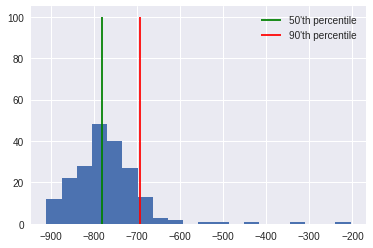

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [0]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states  = [s for i in range(len(states_batch)) if rewards_batch[i]>=reward_threshold for s in states_batch[i]]
    elite_actions = [a for i in range(len(actions_batch)) if rewards_batch[i]>=reward_threshold for a in actions_batch[i]]
    
    return elite_states,elite_actions

In [0]:
from collections import defaultdict
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    
    #Don't forget to set 1/n_actions for all actions in unvisited states.
    state_action_dict = defaultdict(lambda: [0]*n_actions)
    for i in range(len(elite_states)):
        state_action_dict[elite_states[i]][elite_actions[i]]+=1
    for i in range(n_states):
        if i not in state_action_dict:
            new_policy[i] = [1/n_actions]*n_actions
        else:
            new_policy[i] = [p/sum(state_action_dict[i]) for p in state_action_dict[i]]
    
    
    return new_policy

In [0]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [0]:
policy = np.ones([n_states, n_actions]) / n_actions

mean reward = -80.132, threshold=5.000


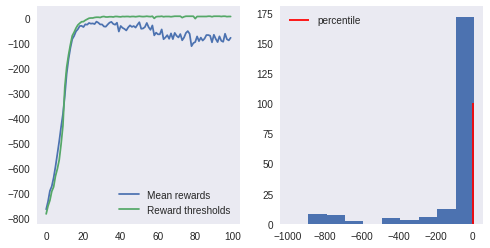

In [0]:
n_sessions = 250  #sample this many sessions
percentile = 50  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    
    sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    batch_states,batch_actions,batch_rewards = zip(*sessions)

    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate * new_policy + (1-learning_rate) * policy
    
    #display results on chart
    show_progress(batch_rewards, log, percentile)